# Grad-CAM with PyTorch: A Hands-on Tutorial

Welcome to this interactive exercise! You will learn how to implement **Gradient-weighted Class Activation Mapping (Grad-CAM)** from scratch.

**What is Grad-CAM?**
It's a technique to visualize *where* a Convolutional Neural Network (CNN) is looking when it makes a prediction. It uses the gradients of the target concept flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image.

## Exercise 1: Setup and Model Loading

First, we need to import the necessary libraries and load a pre-trained model. We'll use **ResNet50**, a standard architecture trained on ImageNet.

**Your Task:**
1.  Import `torch`, `torch.nn.functional` as `F`, `numpy`, `matplotlib.pyplot` as `plt`, and `PIL.Image`.
2.  From `torchvision`, import `models` and `transforms`.
3.  Load a pre-trained `resnet50` model (using `weights=models.ResNet50_Weights.DEFAULT` or `pretrained=True`).
4.  Set the model to evaluation mode using `.eval()`.

In [45]:
# TODO: Import libraries
import torch
import torch.nn.functional as F

import torchvision
from torchvision import models
import torchvision.transforms.v2 as T

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# TODO: Load ResNet50 model and set to eval mode
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [5]:
# --- TEST CELL ---
assert model is not None, "Model is not defined!"
assert isinstance(model, torch.nn.Module), "Model is not a torch Module!"
assert not model.training, "Model should be in evaluation mode (model.eval())!"
print("✅ Exercise 1 Passed!")

✅ Exercise 1 Passed!


## Exercise 2: Image Preprocessing

CNNs expect input images to be normalized and resized to a specific shape (usually 224x224 for ResNet).

**Your Task:**
1.  Define a `transforms.Compose` pipeline that includes:
    *   Resize to `(224, 224)`
    *   Convert to Tensor
    *   Normalize using mean `[0.485, 0.456, 0.406]` and std `[0.229, 0.224, 0.225]`.
2.  Implement `preprocess_image(image_path)` that opens an image, applies transforms, and adds a batch dimension (shape `[1, 3, 224, 224]`).


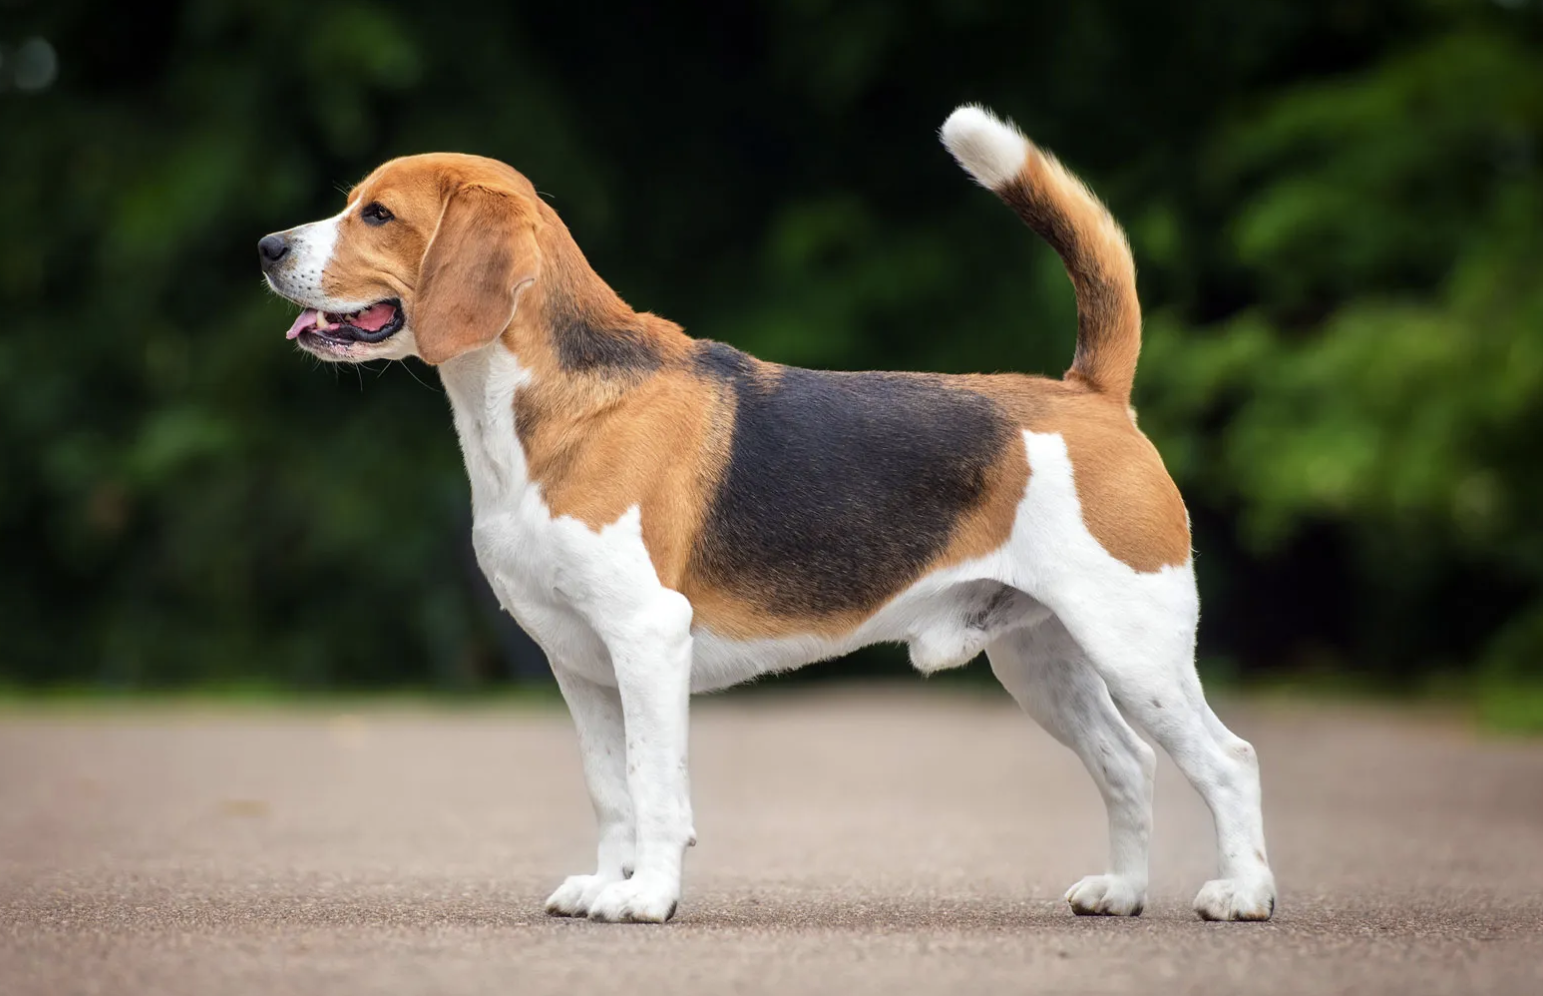

In [12]:
image_path = r"../grad cam\image.png"
Image.open(image_path)

In [36]:
# TODO: Define transforms
transform = T.Compose([
    T.ToImage(),
    T.Resize((224,224)),
    T.ToDtype(torch.float)
])


def preprocess_image(image_path):
    # TODO: Open image, apply transforms, unsqueeze(0)
    img = Image.open(image_path)
    img_trans = transform(img)
    return img_trans.unsqueeze(0)

input_tensor = preprocess_image(image_path)[:,:3,:,:] # remove extra channel

In [37]:
# --- TEST CELL ---
assert input_tensor is not None, "input_tensor is None!"
assert input_tensor.shape == (1, 3, 224, 224), f"Expected shape (1, 3, 224, 224), got {input_tensor.shape}"
print("✅ Exercise 2 Passed!")

✅ Exercise 2 Passed!


## Exercise 3: Understanding and Registering Hooks

### What are Hooks?
In PyTorch, **Hooks** are like listeners that you attach to layers in your network. They let you inspect or modify the data passing through layers without changing the model's architecture.

*   **Forward Hook**: Triggers during the forward pass. We use this to grab the **activations** (feature maps) of the target convolutional layer.
*   **Backward Hook**: Triggers during the backward pass (when we call `.backward()`). We use this to grab the **gradients** flowing back to that layer.

**Your Task:**
Implement the `GradCAM` class setup.
1.  In `__init__`, find the target layer. For ResNet50, we usually use the last convolutional block: `model.layer4[2].conv3`.
2.  Register a forward hook on this layer to save `activations`.
3.  Register a hook to save `gradients`. *Tip: You can use `layer.register_full_backward_hook` OR register a hook on the tensor output from the forward hook using `tensor.register_hook`.*


In [42]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # TODO: Register Hooks
        # 1. Forward hook
        # 2. Backward hook (or tensor hook)
        
        self._register_hooks()

    def save_activation(self, module, input, output):
        # Output from the layer are the activations
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        # grad_output is a tuple, take the first element
        self.gradients = grad_output[0]

    def _register_hooks(self):
        # TODO: Register the hooks on self.target_layer
        
        # register forward hook
        self.target_layer.register_forward_hook(self.save_activation)
        # register backward hook
        self.target_layer.register_full_backward_hook(self.save_gradient)
        

# Initialize GradCAM
target_layer = model.layer4[2].conv3
grad_cam = GradCAM(model, target_layer)

In [43]:
# --- TEST CELL ---
# Perform a dummy pass to see if hooks catch data
output = model(input_tensor)
loss = output.sum()
loss.backward()

assert grad_cam.activations is not None, "Activations not captured! Check forward hook."
assert grad_cam.gradients is not None, "Gradients not captured! Check backward hook."
print("✅ Exercise 3 Passed! Hooks are working.")

✅ Exercise 3 Passed! Hooks are working.


## Exercise 4: Computing the Grad-CAM Heatmap

This is the core logic.

**The Formula:**
1.  **Weights ($w_k$)**: Take the Global Average Pooling of the gradients.
    $$ w_k = \frac{1}{Z} \sum_{i} \sum_{j} \text{gradients}_{k, i, j} $$
2.  **Combination**: Multiply each activation map $A^k$ by its weight $w_k$ and sum them up.
3.  **ReLU**: Apply ReLU to ignore negative contributions (we only care about features that *increase* the class score).
4.  **Normalize**: Scale the heatmap to be between 0 and 1.

**Your Task:**
Implement `generate_heatmap` method.
*   Run a forward pass.
*   Zero grads, backward pass for the specific `class_idx`.
*   Use captured `self.gradients` and `self.activations` to compute the heatmap.

In [46]:
def generate_heatmap(self, input_image, class_idx=None):
    # 1. Forward Pass
    output = self.model(input_image)
    
    if class_idx is None:
        class_idx = torch.argmax(output, dim=1)
    
    # 2. Backward Pass
    self.model.zero_grad()
    target = output[0, class_idx]
    target.backward()
    
    # Get captured data
    gradients = self.gradients
    activations = self.activations
    
    # TODO: Pool the gradients across the height and width (dim 2 and 3)
    # weights shape should be [1, k, 1, 1] or [1, k]
    weights = torch.mean(gradients, dim=(2,3), keepdim=True)
    
    # TODO: Weight the activations
    # (Multiply gradients weights with activations)
    weighted_activations = torch.mul(gradients, weights)
    
    # TODO: Sum across channels (dim 1) to get a 2D map
    heatmap = torch.sum(weighted_activations, dim=1)
    
    # TODO: Apply ReLU
    heatmap = F.relu(heatmap)
    
    # Process for Visualization
    heatmap = heatmap.detach().cpu().numpy()[0]
    
    if np.max(heatmap) == 0:
        pass # Avoid div by zero
    else:
        # TODO: Normalize heatmap between 0 and 1
        heatmap = heatmap / np.max(heatmap)
        
    return heatmap

# Attach method to class (Monkey patching for the exercise flow)
GradCAM.generate_heatmap = generate_heatmap

# Generate heatmap
heatmap = grad_cam.generate_heatmap(input_tensor)

In [47]:
# --- TEST CELL ---
assert heatmap is not None, "Heatmap is None!"
assert len(heatmap.shape) == 2, f"Heatmap should be 2D, got {heatmap.shape}"
assert np.min(heatmap) >= 0 and np.max(heatmap) <= 1, "Heatmap not normalized properly!"
print("✅ Exercise 4 Passed!")

✅ Exercise 4 Passed!


## Exercise 5: Visualization

The heatmap is small (e.g., 7x7). We need to resize it to the original image size and overlay it.

**Your Task:**
1.  Resize heatmap to 224x224.
2.  Convert it to a color map (e.g., Jet or Viridis) - *Since we aren't using OpenCV, we can use matplotlib's cm or PIL.*
3.  Blend it with the original image.

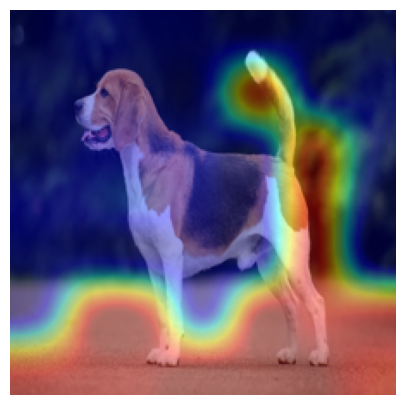

In [59]:
def overlay_heatmap(heatmap, original_image_path):
    img = Image.open(original_image_path).resize((224, 224))
    
    # TODO: Resize heatmap to (224, 224) using PIL or similar
    # Hint: Convert numpy heatmap -> PIL Image -> resize -> numpy
    heatmap_img = np.array(Image.fromarray(255 * heatmap).resize((224,224)))


    # TODO: Colorize (pseudo-coloring)
    # A simple way using matplotlib colormaps:
    colored_map = plt.cm.jet(heatmap_img / 255.0)[:, :, :3] # Get RGB
    
    # TODO: Overlay
    # Hint: weighted sum: 0.6 * original + 0.4 * heatmap
    superimposed_img = 0.6 * np.array(img)[:,:,:3] / 255.0 + 0.4 * colored_map
    
    return superimposed_img

result = overlay_heatmap(heatmap, image_path)

plt.figure(figsize=(10, 5))
plt.imshow(result)
plt.axis('off')
plt.show()